In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime as dt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression

In [2]:
file_path = '~/Google Drive/Datathon II/Data sets/'

In [3]:
# dictionary for courses

course_dict = {26:'primary 1',
                27:'primary 2',
                28:'primary 3',
                29:'primary 4',
                30:'primary 5',
                31:'primary 6'}

In [4]:
# dictionary for subjects

subject_dict = {13:'natural sciences',
               15: 'social sciences',
               54: 'spanish',
               60: 'mathematics',
               65:'music',
               79:'religion'}

In [5]:
# dictionary for support

support_dict = {1:'paper',
               2: 'digital',
               4: 'platform',
               0: 'none'}


In [6]:
language_dict = {11:'gallego',
               13: 'castellano',
               18: 'valenciano',
               26: 'euskera',
                10: 'catalan'}

In [7]:
#read the dataset

file_path = '~/Google Drive/Datathon II/Data sets/'


In [8]:

# School locations

school_locations = pd.read_excel(os.path.join(file_path, 'School locations.xlsx'))

school_locations['Customer heading'] = school_locations['Customer heading'].astype('int')

#filter for schools in madrid

madrid_schools = list(school_locations[(school_locations['Province'] == 'Madrid') | 
                 (school_locations['Province'] == 'MADRID') | 
                 (school_locations['Province'] == 'Madrid (Comunidad de Madrid)')]['Customer heading'])

df_locations = school_locations[school_locations['Customer heading'].isin(madrid_schools)]

### Survey Dataset

In [9]:
# read survey files

survey_2015 = pd.read_csv(os.path.join(file_path, '2015Surveys_sample.csv'),sep=';')
survey_2016 = pd.read_csv(os.path.join(file_path, '2016Surveys_sample.csv'),sep=';')
survey_2017 = pd.read_csv(os.path.join(file_path, '2017Surveys_sample.csv'),sep=';')
survey_2018 = pd.read_csv(os.path.join(file_path, '2018Surveys_sample.csv'),sep=';')
survey_2019 = pd.read_csv(os.path.join(file_path, '2019Surveys_sample.csv'),sep=';')

# filter for educational material

survey_2015 = survey_2015[(survey_2015['Educational material']==1) & 
                          (survey_2015['Subject'].isin((list(subject_dict.keys()))))  &
                         (survey_2015['Customer heading'].isin(madrid_schools))].drop('Educational material',axis=1)

survey_2016 = survey_2016[survey_2016['Educational Material']==1 & 
                          (survey_2016.Subject.isin((list(subject_dict.keys())))) &
                         (survey_2016['Customer heading'].isin(madrid_schools))].drop('Educational Material',axis=1)

survey_2017 = survey_2017[survey_2017['Educational Material']==1 &
                          (survey_2017.Subject.isin((list(subject_dict.keys())))) &
                         (survey_2017['Customer heading'].isin(madrid_schools))].drop('Educational Material',axis=1)

survey_2018 = survey_2018[survey_2018['Educational Material']==1 & 
                          (survey_2018.Subject.isin((list(subject_dict.keys())))) &
                         (survey_2018['Customer heading'].isin(madrid_schools))].drop('Educational Material',axis=1)


survey_2019 = survey_2019[survey_2019['Educational material']==1 & 
                          (survey_2019.Subject.isin((list(subject_dict.keys())))) &
                         (survey_2019['Customer heading'].isin(madrid_schools))].drop('Educational material',axis=1)

#change year to category
survey_2015['Publishing group'] = survey_2015['Publishing group'].astype('object')
survey_2016['Publishing group'] = survey_2016['Publishing group'].astype('object')
survey_2017['Publishing group'] = survey_2017['Publishing group'].astype('object')
survey_2018['Publishing group'] = survey_2018['Publishing group'].astype('object')
survey_2019['Publishing group'] = survey_2019['Publishing group'].astype('object')

#change year to object
survey_2015['Year'] = survey_2015['Year'].astype('object')
survey_2016['Year'] = survey_2016['Year'].astype('object')
survey_2017['Year'] = survey_2017['Year'].astype('object')
survey_2018['Year'] = survey_2018['Year'].astype('object')
survey_2019['Year'] = survey_2019['Year'].astype('object')


# survey file as one
survey = pd.concat([survey_2015,survey_2016,survey_2017,survey_2018,survey_2019],sort=False)

# remove all duplicated rows

survey = survey.drop_duplicates()

# map relevant values

survey['Course'] = survey['Course'].map(course_dict)
survey['Subject'] = survey['Subject'].map(subject_dict)
survey['Type Current Support'] = survey['Type Current Support'].map(support_dict)
survey['Language'] = survey['Language'].map(language_dict)

# survey_academic year

survey['Customer heading'] = survey['Customer heading'].astype('int')

#remove all nulls and that is the final dataset
survey.to_csv(os.path.join(file_path,'survey_clean.csv'))

In [10]:
survey_2019.head()

,Year,Course,Subject,Language,Type Current Support,# copies,Publishing group,Customer heading
258235,2019,29,65,13,1,135,34,136369.0
258236,2019,29,79,13,1,0,1,136369.0
258237,2019,29,60,13,1,0,1,136369.0
258239,2019,29,54,13,1,135,1,136369.0
258244,2019,30,15,13,1,140,1,136369.0


In [11]:
df_survey = survey[(survey['Publishing group'] == '1') | (survey['Publishing group'] == 1)].drop(['Publishing group','Language','Type Current Support'],axis=1)


count = df_survey.groupby(['Customer heading','Year'])['Course'].count().reset_index()
count.columns = ['Customer heading','Year','Count_Activities']

df_survey = df_survey.merge(count,left_on=['Customer heading','Year'], 
                            right_on=['Customer heading','Year'])

df_survey.to_csv(os.path.join(file_path,'df_survey.csv'))

### Market Share Dataset

In [12]:
# market share dataset

market_share=pd.DataFrame(survey.groupby(['Year','Subject','Type Current Support','Course'])['# copies'].sum()).reset_index().dropna()
market_share.to_csv(os.path.join(file_path,'market_share.csv'))

market_share.tail()

# company share dataset

company_share = pd.DataFrame(survey[(survey['Publishing group'] == '1') | (survey['Publishing group'] == 1)].groupby(['Year','Subject','Type Current Support','Course'])['# copies'].sum()).reset_index().dropna()

In [13]:
# merging the two

full_share = market_share.merge(company_share, 
                                             left_on=['Year','Subject','Type Current Support','Course'],
                                             right_on=['Year','Subject','Type Current Support','Course'])

# changing the column names

full_share.columns  = ['Year','Subject','Type Current Support','Course','Copies Market','Copies Client']

# full market share

full_share.head()

# calculating the clients market share

full_share['Client Market Share'] = full_share['Copies Client'] / full_share['Copies Market'] * 100


# only the ones we want for digital

digital = full_share[(full_share['Type Current Support'] == 'digital') * (full_share['Course'].isin(['primary 5', 'primary 6']))]


# only the one we want for paper

paper = full_share[full_share['Type Current Support'] == 'paper'][full_share['Subject']!= 'natural sciences']


# concat the two

full_share = pd.concat([digital,paper])

# send to csv

full_share.to_csv(os.path.join(file_path,'client_market_share.csv'),index=False)

C:\Users\anups\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]
C:\Users\anups\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [14]:
full_share.head()

,Year,Subject,Type Current Support,Course,Copies Market,Copies Client,Client Market Share
4,2015,mathematics,digital,primary 5,1213,377,31.079967
5,2015,mathematics,digital,primary 6,1262,362,28.684628
15,2015,music,digital,primary 5,447,115,25.727069
16,2015,music,digital,primary 6,457,41,8.971554
26,2015,natural sciences,digital,primary 5,320,189,59.062500


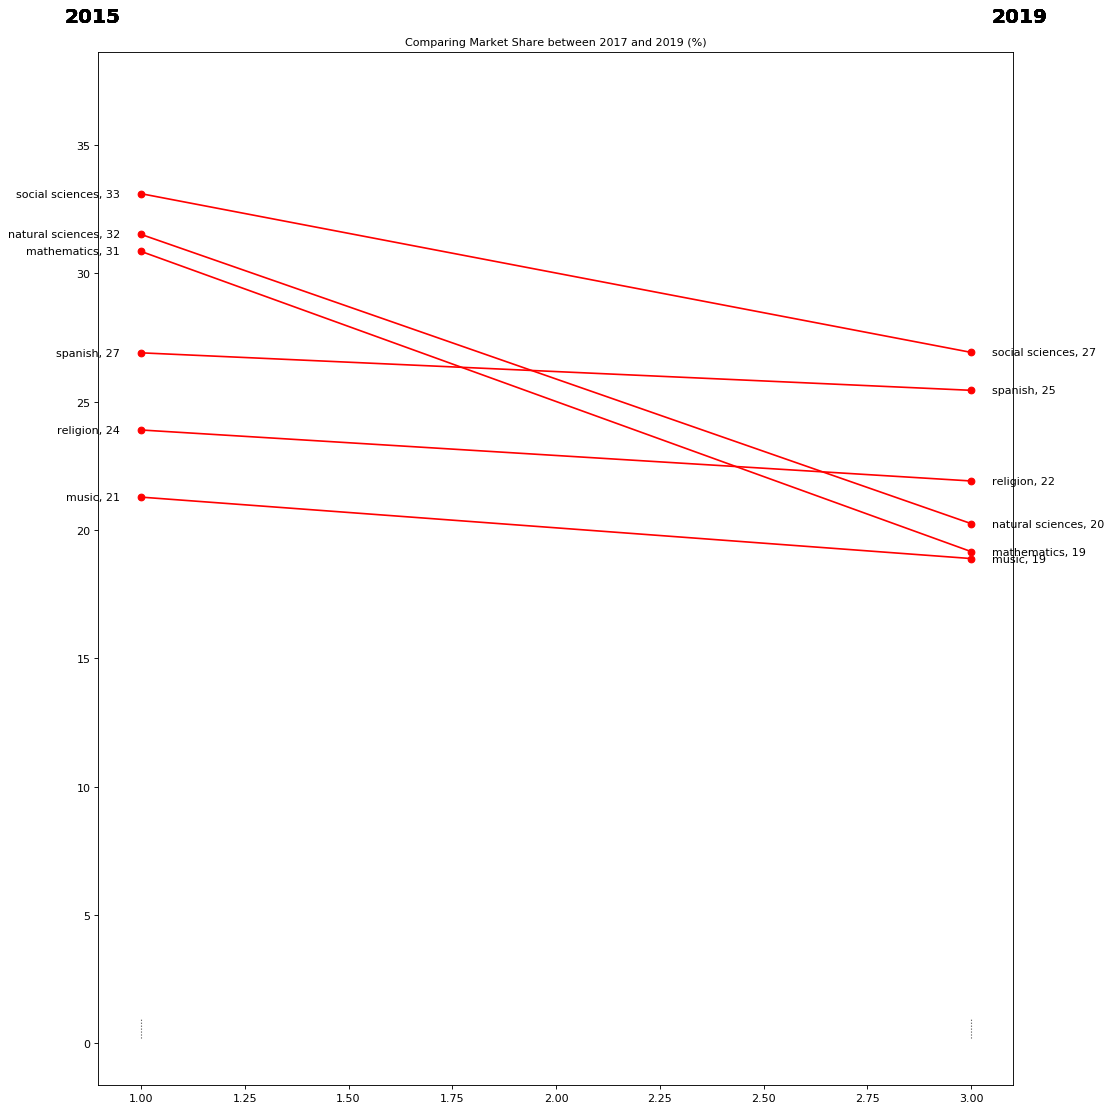

In [83]:
import matplotlib.lines as mlines

with plt.style.context('tableau-colorblind10'):

# Import Data
    df = df

    left_label = [str(c) + ', '+ str(round(y)) for c, y in zip(df['Subject'], df.loc[df['Year']==2019,'Client Market Share'])]
    right_label = [str(c) + ', '+ str(round(y)) for c, y in zip(df['Subject'], df.loc[df['Year']==2015,'Client Market Share'])]
    klass = ['red' if (y1-y2) < 0 else 'green' for y1, y2 in zip(df.loc[df['Year']==2015,'Client Market Share'], df.loc[df['Year']==2019,'Client Market Share'])]

# draw line
    def newline(p1, p2, color='black'):
        ax = plt.gca()
        l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='red' if p1[1]-p2[1] > 0 else 'green', marker='o', markersize=6)
        ax.add_line(l)
        return l

    fig, ax = plt.subplots(1,1,figsize=(14,14), dpi= 80)

# Vertical Lines
    ax.vlines(x=1, ymin=0.2, ymax=1, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
    ax.vlines(x=3, ymin=0.2, ymax=1, color='black', alpha=0.7, linewidth=1, linestyles='dotted')

# Points
    ax.scatter(y=df.loc[df['Year']==2019,'Client Market Share'], x=np.repeat(1, df.loc[df['Year']==2019,'Client Market Share'].shape), s=5, color='white', alpha=0.7)
    ax.scatter(y=df.loc[df['Year']==2015,'Client Market Share'], x=np.repeat(1, df.loc[df['Year']==2015,'Client Market Share'].shape), s=5, color='white', alpha=0.7)

# Line Segmentsand Annotation
    for p1, p2, c in zip(df.loc[df['Year']==2015,'Client Market Share'], df.loc[df['Year']==2019,'Client Market Share'],df['Subject'].unique()):
        newline([1,p1], [3,p2])
        ax.text(1-0.05, p1, c + ', ' + str(round(p1)), horizontalalignment='right', verticalalignment='center', fontdict={'size':10})
        ax.text(3+0.05, p2, c + ', ' + str(round(p2)), horizontalalignment='left', verticalalignment='center', fontdict={'size':10})

# 'Before' and 'After' Annotations
        ax.text(1-0.05, 40, '2015', horizontalalignment='right', verticalalignment='center', fontdict={'size':18, 'weight':700})
        ax.text(3+0.05, 40, '2019', horizontalalignment='left', verticalalignment='center', fontdict={'size':18, 'weight':700})

# Decoration
        ax.set_title("Comparing Market Share between 2017 and 2019 (%)", fontdict={'size':10})
        plt.tight_layout()
        plt.savefig('segments')

In [55]:
left_label = [str(c) + ', '+ str(round(y)) for c, y in zip(df['Subject'], df.loc[df['Year']==2019,'Client Market Share'])]

In [40]:
df = full_share[['Year','Client Market Share','Subject']] 

In [42]:
df

,Year,Client Market Share,Subject
0,2015,30.850562,mathematics
1,2015,21.278481,mathematics
2,2015,31.513204,mathematics
3,2015,23.893759,mathematics
4,2015,33.099085,mathematics
...,...,...,...
175,2019,20.084439,spanish
176,2019,21.630480,spanish
177,2019,24.255503,spanish
178,2019,26.403430,spanish


In [15]:
# market share dataset

market_share_new=pd.DataFrame(survey.groupby(['Year','Subject','Course'])['# copies'].sum()).reset_index().dropna()
market_share_new.to_csv(os.path.join(file_path,'market_share.csv'),index=False)

market_share.tail()

# company share dataset

company_share_new = pd.DataFrame(survey[(survey['Publishing group'] == '1') | (survey['Publishing group'] == 1)].groupby(['Year','Subject','Course'])['# copies'].sum()).reset_index().dropna()

In [16]:
market_share_new.head()

,Year,Subject,Course,# copies
0,2015,mathematics,primary 1,42372
1,2015,mathematics,primary 2,39500
2,2015,mathematics,primary 3,44191
3,2015,mathematics,primary 4,38441
4,2015,mathematics,primary 5,41409


In [17]:
# merging the two

full_share = market_share_new.merge(company_share_new, 
                                             left_on=['Year','Subject','Course'],
                                             right_on=['Year','Subject','Course'])

# changing the column names

full_share.columns  = ['Year','Subject','Course','Copies Market','Copies Client']

# full market share

full_share.head()

# calculating the clients market share

full_share['Client Market Share'] = full_share['Copies Client'] / full_share['Copies Market'] * 100


## full share csv

full_share.to_csv(os.path.join(file_path,'client_market_share_wp.csv'),index=False)

### Marketing Dataset

In [18]:
# read the three marketign activities file

mkt_2015 = pd.read_csv(os.path.join(file_path,"2015.csv"),dtype={'Customer heading': str})

mkt_2016 = pd.read_csv(os.path.join(file_path,"2016.csv"),dtype={'Customer heading': str})

mkt_2017_2019 = pd.read_csv(os.path.join(file_path,"2019_2017.csv"),dtype={'Customer heading': str})

#concatenating different excel sheets
frames = [mkt_2015 , mkt_2016, mkt_2017_2019]
mkt = pd.concat(frames)

#filling NAs
mkt = mkt.fillna(0)

#summing the number of items in all marketing actions
mkt['number_items'] = mkt['# Mkt_action 1'] + mkt['# Mkt_action 2'] + mkt['# Mkt_action 3']

#dummifying marketing actions
mkt['Mkt 1'] = np.where(mkt['# Mkt_action 1'] > 0, 1, 0)
mkt['Mkt 2'] = np.where(mkt['# Mkt_action 2'] > 0, 1, 0)
mkt['Mkt 3'] = np.where(mkt['# Mkt_action 3'] > 0, 1, 0)

#getting months out of the data so we can take into consideran an academic year
mkt['Day sent'] = pd.to_datetime(mkt['Day sent'])
mkt['Month'] = mkt['Day sent'].dt.month

#getting the academic year
mkt['Year&Month'] = mkt['Year'].map(str) + '-' + mkt['Month'].map(str)
mkt['Academic_Year'] = np.where(mkt['Month'] > 6, mkt['Year'] + 1, mkt['Year'])

mkt = mkt[mkt['Customer heading'].isin(list(map(str, madrid_schools)))].drop_duplicates()
mkt['Customer heading'] = mkt['Customer heading'].astype('int')

df_marketing = mkt.copy()

df_marketing['returns_1'] = np.where(df_marketing['# Mkt_action 1'] < 0, df_marketing['# Mkt_action 1'],0)
df_marketing['returns_2'] = np.where(df_marketing['# Mkt_action 2'] < 0, df_marketing['# Mkt_action 2'],0)
df_marketing['returns_3'] = np.where(df_marketing['# Mkt_action 3'] < 0, df_marketing['# Mkt_action 3'],0)

df_marketing['returns'] = df_marketing['returns_1'] + df_marketing['returns_2'] + df_marketing['returns_3']

df_marketing = df_marketing.drop(['returns_1','returns_2','returns_3'],axis=1)

df_marketing.to_csv(os.path.join(file_path,'df_marketing.csv'),index=False)

In [19]:
mkt.shape

(104431, 13)

### Activities Dataset

In [20]:
# read activities

activities = pd.read_excel(os.path.join(file_path,"Activities.xlsx"))

#filter for madrid scools

activities = activities[activities['Customer heading'].isin(madrid_schools)]

# fill na in commercial

activities['Type activity'] = activities['Type activity'].fillna('Unknown')

# get month

activities['Month'] = activities['Date'].dt.month

# year

activities['Year'] = activities['Date'].dt.year

activities['Academic_Year'] = np.where(activities['Month'] > 6, activities['Year'] + 1, activities['Year'])

activity_count = activities.groupby(['Customer heading', 'Academic_Year'])['Type activity'].count().reset_index()

activity_count.columns = ['Customer heading', 'Academic_Year','Count']

activities_dummy = pd.get_dummies(activities[['Customer heading','Academic_Year','Type activity']])

activities_new = activity_count.merge(activities_dummy,left_on=['Customer heading','Academic_Year'], right_on=['Customer heading','Academic_Year'])

year_1 = dt.datetime.strptime('2017-06-30', '%Y-%M-%d')
year_2 = dt.datetime.strptime('2018-06-30', '%Y-%M-%d')
year_3 = dt.datetime.strptime('2019-06-30', '%Y-%M-%d')
year_4 = dt.datetime.strptime('2020-06-30', '%Y-%M-%d')

activities[(activities['Date'] > year_1) & (activities['Date'] < year_2)]

activities['year_1'] = activities['Date'] - year_1
activities['year_2'] = activities['Date'] - year_2
activities['year_3'] = activities['Date'] - year_3
activities['year_4'] = activities['Date'] - year_4

activities['year_1'] = activities['year_1'].apply(lambda x: np.where((x.days > 0) & (x.days <= 365),x.days,0))
activities['year_2'] = activities['year_2'].apply(lambda x: np.where((x.days > 0) & (x.days <= 365),x.days,0))
activities['year_3'] = activities['year_3'].apply(lambda x: np.where((x.days > 0) & (x.days <= 365),x.days,0))
activities['year_4'] = activities['year_4'].apply(lambda x: np.where((x.days > 0) & (x.days <= 365),x.days,0))

activities['days']= activities[['year_1','year_2','year_3','year_4']].sum(axis=1)

activities_min_max = activities.groupby(['Customer heading','Academic_Year'])['days'].agg(['min','max']).reset_index()

activities_min_max.head()

activities['Delegation'].unique()

activities_min_max.columns = ['Customer heading','Academic_Year','First Day','Last Day']

df_activities = activities_new.merge(activities_min_max, left_on=['Customer heading','Academic_Year'], right_on=['Customer heading','Academic_Year'])

df_activities.head()

# count by department


dept_1 = activities.groupby(['Customer heading', 'Academic_Year','Cicle / Department 1'])['Type activity'].nunique().reset_index()
dept_1['index']=dept_1['Customer heading'].astype('str') + str('_')+ dept_1['Academic_Year'].astype('str')
dept_1 = dept_1.pivot(index='index',columns='Cicle / Department 1',values='Type activity')

dept_2 = activities.groupby(['Customer heading', 'Academic_Year','Cicle / Department 2'])['Type activity'].nunique().reset_index()
dept_2['index']=dept_2['Customer heading'].astype('str') + str('_')+ dept_2['Academic_Year'].astype('str')
dept_2=dept_2.pivot(index='index',columns='Cicle / Department 2',values='Type activity')

dept_3 = activities.groupby(['Customer heading', 'Academic_Year','Cicle / Department 3'])['Type activity'].nunique().reset_index()
dept_3['index']=dept_3['Customer heading'].astype('str') + str('_')+ dept_3['Academic_Year'].astype('str')
dept_3=dept_3.pivot(index='index',columns='Cicle / Department 3',values='Type activity')

dept_4 = activities.groupby(['Customer heading', 'Academic_Year','Cicle / Department 4'])['Type activity'].nunique().reset_index()
dept_4['index']=dept_4['Customer heading'].astype('str') + str('_')+ dept_4['Academic_Year'].astype('str')
dept_4=dept_4.pivot(index='index',columns='Cicle / Department 4',values='Type activity')

stacked_dept = pd.concat([dept_1,dept_2,dept_3,dept_4])

final_depts = stacked_dept.groupby('index').sum().reset_index()

final_depts['Customer heading'] = final_depts['index'].apply(lambda x: x.split('_')[0]).astype('float')
final_depts['Academic_Year'] = final_depts['index'].apply(lambda x: x.split('_')[1]).astype('float')

final_depts = final_depts.drop('index',axis=1)

df_activities = df_activities.merge(final_depts, left_on=['Customer heading','Academic_Year'], right_on=['Customer heading','Academic_Year']).drop_duplicates()

df_activities['Customer heading'] = df_activities['Customer heading'].astype('int')

df_activities.to_csv(os.path.join(file_path, 'df_activities.csv'),index=False)

C:\Users\anups\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [21]:
df_activities.duplicated().sum()

0

### Dates dataset

In [22]:
# read dates

dates = pd.read_excel(os.path.join(file_path,"Dates.xlsx"),parse_dates=True).dropna(axis=1).drop(['Course_Start','Course_End'],axis=1)

In [23]:
df_dates = dates.pivot(index='Academic_Year',columns='Type',values='Max_Date')

In [24]:
df_dates.head()

Type,Marketing action 1,Marketing action 2,Marketing action 3
Academic_Year,,,
2015,2015-04-30,2014-11-30,2014-09-30
2016,2016-04-30,2015-11-30,2015-09-30
2017,2017-04-30,2016-11-30,2016-09-30
2018,2018-04-30,2017-11-30,2017-09-30
2019,2019-04-30,2018-11-30,2018-09-30


### Coverage Dataset

In [25]:
df_coverage = pd.read_csv(os.path.join(file_path,'coverage_features.csv')).drop(['Course','Subject','# copies','teacher','churn'],axis=1).drop_duplicates(['Customer heading','Year'])

In [26]:
df_coverage.head()

,Year,Customer heading,Covered this year,Num customers of rep,Tenure of rep,Covered in the past 3y,Covered in the past 4y,Num of reps in 2y,Num of reps in 3y,Num of reps in 4y,Num of reps in 5y,Same rep in years,Cons years covered,Decaying coverage
0,2015,136377,1.0,49.0,5,3.0,4.0,1,1,1,1,5,5,2.283333
1,2015,136384,1.0,37.0,3,3.0,4.0,2,2,2,3,1,5,2.283333
2,2015,136387,1.0,45.0,5,3.0,4.0,1,1,1,2,4,5,2.283333
3,2015,136393,1.0,45.0,5,3.0,4.0,2,2,2,3,1,5,2.283333
4,2015,136405,1.0,45.0,5,3.0,4.0,1,1,1,2,4,5,2.283333


### Churn Calculation

In [27]:
df_survey['teacher'] = df_survey['Customer heading'].astype(str) + '_' + df_survey['Subject'] + '_' + df_survey['Course']
df_survey = df_survey.drop_duplicates()

churn_targets = df_survey.pivot(index='teacher', columns='Year', values='# copies').fillna(0)

for year in [2015,2016,2017,2018]:
    colname = 'churn_' + str(year)
    churn_targets[colname] = churn_targets.apply(lambda row: 1 if (row[year] > 0) and (row[year+1] == 0) else 0, axis=1)

def assign_churn_target(row):
    if row.Year == 2019:
        return np.nan
    else:
        colname = 'churn_' + str(row.Year)
        return churn_targets.loc[row.teacher, colname]

df_survey['churn'] = df_survey.apply(lambda row: assign_churn_target(row), axis=1)

### Merging

In [28]:
## MERGE SURVEY AND LOCATION

df_locations = pd.read_csv(os.path.join(file_path,'location_features.csv'))


survey_location = df_survey.merge(df_locations,left_on='Customer heading',right_on='Customer heading')

survey_location.to_csv(os.path.join(file_path,'survey_location.csv'))

print(df_survey.shape)
print(df_locations.shape)
print(survey_location.shape)
survey_location.head()

(30918, 8)
(821, 9)
(30918, 16)


,Year,Course,Subject,# copies,Customer heading,Count_Activities,teacher,churn,Num customers of seller,Area covered by seller,Seller portfolio - Catholic (abs),Seller portfolio - Private (abs),Seller portfolio - Catholic (relative),Seller portfolio - Private (relative),Institution = Yes % (relative),Institution = Yes % (abs)
0,2015,primary 1,natural sciences,17,136377,16,136377_natural sciences_primary 1,1.0,58,0.193443,0.039326,0.023077,0.12069,0.051724,0.87931,0.086003
1,2015,primary 1,social sciences,17,136377,16,136377_social sciences_primary 1,1.0,58,0.193443,0.039326,0.023077,0.12069,0.051724,0.87931,0.086003
2,2015,primary 1,mathematics,17,136377,16,136377_mathematics_primary 1,1.0,58,0.193443,0.039326,0.023077,0.12069,0.051724,0.87931,0.086003
3,2015,primary 2,natural sciences,19,136377,16,136377_natural sciences_primary 2,1.0,58,0.193443,0.039326,0.023077,0.12069,0.051724,0.87931,0.086003
4,2015,primary 2,spanish,19,136377,16,136377_spanish_primary 2,1.0,58,0.193443,0.039326,0.023077,0.12069,0.051724,0.87931,0.086003


In [29]:
## MERGE MARKETING & DATES
# loosing rows because not data for 2015 / 2016

marketing_dates = df_marketing.merge(df_dates,right_on='Academic_Year',left_on='Academic_Year')


# adding the delays to marketing


marketing_dates['action_delay_1']=np.where(((marketing_dates['# Mkt_action 1'] > 0) & 
                                  (marketing_dates['Day sent'] > marketing_dates['Marketing action 1']))
                                 ,marketing_dates['Day sent']-marketing_dates['Marketing action 1'],0)

marketing_dates['action_delay_2']=np.where(((marketing_dates['# Mkt_action 2'] > 0) & 
                                  (marketing_dates['Day sent'] > marketing_dates['Marketing action 2']))
                                 ,marketing_dates['Day sent']-marketing_dates['Marketing action 2'],0)

marketing_dates['action_delay_3']=np.where(((marketing_dates['# Mkt_action 3'] > 0) & 
                                  (marketing_dates['Day sent'] > marketing_dates['Marketing action 3']))
                                 ,marketing_dates['Day sent']-marketing_dates['Marketing action 3'],0)

marketing_dates['action_delay_1'] = marketing_dates['action_delay_1'].dt.days
marketing_dates['action_delay_2'] = marketing_dates['action_delay_2'].dt.days
marketing_dates['action_delay_3'] = marketing_dates['action_delay_3'].dt.days


marketing_dates = marketing_dates.drop(['Year','# Mkt_action 1',
       '# Mkt_action 2', '# Mkt_action 3','Year&Month','Month','Marketing action 3','Marketing action 2','Marketing action 1','Day sent'],axis=1)


marketing_dates = marketing_dates.groupby(['Customer heading','Academic_Year']).sum().reset_index()

print(df_marketing.shape)
print(df_dates.shape)
print(marketing_dates.shape)
marketing_dates.head()

(104431, 14)
(6, 3)
(8242, 10)


,Customer heading,Academic_Year,number_items,Mkt 1,Mkt 2,Mkt 3,returns,action_delay_1,action_delay_2,action_delay_3
0,136369,2015,96.0,22,9,0,-1.0,621,1077,0
1,136369,2016,346.0,49,47,11,-1.0,81,763,223
2,136369,2017,172.0,14,31,23,-3.0,226,810,103
3,136369,2018,194.0,38,14,12,-29.0,54,209,1732
4,136369,2019,254.0,11,24,20,-2.0,66,96,131


In [30]:
# MERGE SURVEY + LOCATION + MARKETING + DATES


survey_location_marketing_dates = survey_location.merge(marketing_dates,left_on=['Customer heading','Year'],right_on=['Customer heading','Academic_Year'],how='outer').drop('teacher',axis=1)
print(survey_location_marketing_dates.shape)
survey_location_marketing_dates.head()

(35745, 24)


,Year,Course,Subject,# copies,Customer heading,Count_Activities,churn,Num customers of seller,Area covered by seller,Seller portfolio - Catholic (abs),...,Institution = Yes % (abs),Academic_Year,number_items,Mkt 1,Mkt 2,Mkt 3,returns,action_delay_1,action_delay_2,action_delay_3
0,2015,primary 1,natural sciences,17.0,136377,16.0,1.0,58.0,0.193443,0.039326,...,0.086003,2015.0,8.0,1.0,5.0,0.0,0.0,0.0,476.0,0.0
1,2015,primary 1,social sciences,17.0,136377,16.0,1.0,58.0,0.193443,0.039326,...,0.086003,2015.0,8.0,1.0,5.0,0.0,0.0,0.0,476.0,0.0
2,2015,primary 1,mathematics,17.0,136377,16.0,1.0,58.0,0.193443,0.039326,...,0.086003,2015.0,8.0,1.0,5.0,0.0,0.0,0.0,476.0,0.0
3,2015,primary 2,natural sciences,19.0,136377,16.0,1.0,58.0,0.193443,0.039326,...,0.086003,2015.0,8.0,1.0,5.0,0.0,0.0,0.0,476.0,0.0
4,2015,primary 2,spanish,19.0,136377,16.0,1.0,58.0,0.193443,0.039326,...,0.086003,2015.0,8.0,1.0,5.0,0.0,0.0,0.0,476.0,0.0


In [31]:
# MERGE SURVEY + LOCATION + MARKETING + DATES + ACTVITY

survey_location_marketing_dates_activity = survey_location_marketing_dates.merge(df_activities,left_on=['Customer heading',
                                                                                                          'Academic_Year'],
                                                                                 right_on=['Customer heading','Academic_Year'],how='outer')

print(survey_location_marketing_dates_activity.shape)
survey_location_marketing_dates_activity.head()

(51538, 74)


,Year,Course,Subject,# copies,Customer heading,Count_Activities,churn,Num customers of seller,Area covered by seller,Seller portfolio - Catholic (abs),...,PRIMARY,QUALITY,REGIONAL LANGUAGE,RELIGION (INFANT),RELIGION (PRIMARY),RELIGION (SECONDARY),SCIENCE,SPANISH LANGUAGE,TECHNOLOGY,UNALLOCATED
0,2015,primary 1,natural sciences,17.0,136377,16.0,1.0,58.0,0.193443,0.039326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,primary 1,social sciences,17.0,136377,16.0,1.0,58.0,0.193443,0.039326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,primary 1,mathematics,17.0,136377,16.0,1.0,58.0,0.193443,0.039326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,primary 2,natural sciences,19.0,136377,16.0,1.0,58.0,0.193443,0.039326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,primary 2,spanish,19.0,136377,16.0,1.0,58.0,0.193443,0.039326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
survey_location_marketing_dates_activity.duplicated().sum()

0

In [33]:
# MERGE SURVEY + LOCATION + MARKETING + DATES + ACTVITY

survey_location_marketing_dates_activity_coverage = survey_location_marketing_dates_activity.merge(df_coverage,left_on=['Customer heading',
                                                                                                          'Academic_Year'],
                                                                                 right_on=['Customer heading','Year'])

print(survey_location_marketing_dates_activity_coverage.shape)
survey_location_marketing_dates_activity_coverage.head()

(45046, 87)


,Year_x,Course,Subject,# copies,Customer heading,Count_Activities,churn,Num customers of seller,Area covered by seller,Seller portfolio - Catholic (abs),...,Tenure of rep,Covered in the past 3y,Covered in the past 4y,Num of reps in 2y,Num of reps in 3y,Num of reps in 4y,Num of reps in 5y,Same rep in years,Cons years covered,Decaying coverage
0,2015,primary 1,natural sciences,17.0,136377,16.0,1.0,58.0,0.193443,0.039326,...,5,3.0,4.0,1,1,1,1,5,5,2.283333
1,2015,primary 1,social sciences,17.0,136377,16.0,1.0,58.0,0.193443,0.039326,...,5,3.0,4.0,1,1,1,1,5,5,2.283333
2,2015,primary 1,mathematics,17.0,136377,16.0,1.0,58.0,0.193443,0.039326,...,5,3.0,4.0,1,1,1,1,5,5,2.283333
3,2015,primary 2,natural sciences,19.0,136377,16.0,1.0,58.0,0.193443,0.039326,...,5,3.0,4.0,1,1,1,1,5,5,2.283333
4,2015,primary 2,spanish,19.0,136377,16.0,1.0,58.0,0.193443,0.039326,...,5,3.0,4.0,1,1,1,1,5,5,2.283333


In [34]:
survey_location_marketing_dates_activity_coverage.duplicated().sum()

0

In [35]:
#churn rates

print(survey_location.groupby('Course')['churn'].mean())
print(survey_location.groupby('Subject')['churn'].mean())

#print(survey_location.groupby('Institution')['churn'].mean())
#print(survey_location.groupby('Titularity')['churn'].mean())
print(survey_location['churn'].mean())
print(survey_location.groupby('Year')['churn'].mean())

Course
primary 1    0.421527
primary 2    0.397825
primary 3    0.402262
primary 4    0.388374
primary 5    0.379288
primary 6    0.378343
Name: churn, dtype: float64
Subject
mathematics         0.392055
music               0.390207
natural sciences    0.411295
religion            0.387538
social sciences     0.400873
spanish             0.385446
Name: churn, dtype: float64
0.39372074882995317
Year
2015    0.293273
2016    0.349724
2017    0.454289
2018    0.489909
2019         NaN
Name: churn, dtype: float64


### Modelling

In [528]:
df_final = survey_location_marketing_dates_activity_coverage.copy()

df_final.to_csv(os.path.join(file_path,'final_dataset.csv'),index=False)

In [529]:
df_final.columns = df_final.columns.str.lower()

In [530]:
df_final['churn'].dropna().shape

(29688,)

In [38]:
df_final.index = df_final['customer heading']

In [39]:
df_final = df_final.drop(['year_x','year_y','course','# copies','customer heading','academic_year','subject'],axis=1).dropna()

In [40]:
df_final = pd.get_dummies(df_final)

In [41]:
X = df_final.drop('churn',axis=1).values
y = df_final['churn'].values

In [42]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [43]:
rf = RandomForestClassifier(random_state=42,n_estimators=1000)

In [44]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [45]:
pd.DataFrame(rf.feature_importances_,index=df_final.drop('churn',axis=1).columns, columns=['feature_importance']).sort_values('feature_importance',ascending=False).head(20)

,feature_importance
number_items,0.056894
mkt 1,0.053996
last day,0.049652
type activity_unknown,0.048968
type activity_commercial,0.047708
first day,0.047633
count_activities,0.044895
count,0.044332
mkt 2,0.043595
mkt 3,0.038366


In [46]:
train_pred = rf.predict_proba(X_train)[:,1]

roc_auc_score(y_train,train_pred)

0.787029856404106

In [47]:
y_pred_prob = rf.predict_proba(X_test)
y_pred = rf.predict(X_test)

In [48]:
y_pred_prob = rf.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_pred_prob)

0.6671539366709457

In [49]:
confusion_matrix(y_test,y_pred)

array([[720, 305],
       [394, 518]], dtype=int64)

## Modelling

In [540]:
score_dictionary_lgbm = {}
best_models_lgbm = {}

for i in subject_dict.values():
    
    df_final = pd.read_csv(os.path.join(file_path,'train_set.csv'))
    
    subject = i
    
    df_final = df_final[(df_final['Subject']==subject)]

    df_final = df_final.drop(['Customer heading','Subject'],axis=1)
    
    X = df_final.drop('churn',axis=1).values
    y = df_final['churn'].values

    param_grid = {'num_leaves':[7,15, 31, 63,127],'min_data_in_leaf': [20,50,100,150],'n_estimators':[50,200]}
   
    model = lgbm.LGBMClassifier(random_state=42)
        
    grid = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1, cv=5, verbose=10)
    
    grid.fit(X,y)
    
    best_model = grid.best_estimator_
    best_score = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')['mean_test_score'][0]
    
    best_models_lgbm[i] = best_model # save model to dictionary
    score_dictionary_lgbm[i] = best_score 

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1566s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0228s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:    8.3s
[Parallel(n_j

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1705s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0040s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 126 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:    9.4s
[Parallel(n_j

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 198 out of 200 | elapsed:  

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 198 out of 200 | elapsed:  

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0788s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 156 out of 200 | elapsed:    3.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.6s finished


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1765s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0018s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 175 tasks      | elapsed:    9.5s
[Parallel(n_j

In [549]:
lgbm_scores = pd.DataFrame(score_dictionary_lgbm.values(),score_dictionary_lgbm.keys(),columns=['cv_scores_lgbm'])

lgbm_scores.to_csv(os.path.join(file_path,'lgbm_scores.csv'))

In [550]:
lgbm_scores

,cv_scores_lgbm
natural sciences,0.610322
social sciences,0.616756
spanish,0.657430
mathematics,0.627345
music,0.528615
religion,0.638221


In [551]:
score_dictionary_rf = {}
best_models_rf = {}

In [552]:
for i in subject_dict.values():
    
    df_final = pd.read_csv(os.path.join(file_path,'train_set.csv'))
    
    subject = i
    
    df_final = df_final[(df_final['Subject']==subject)]

    df_final = df_final.drop(['Customer heading','Subject'],axis=1)
    
    X = df_final.drop('churn',axis=1).values
    y = df_final['churn'].values
    
    param_grid = {
    'max_features': ['sqrt','log2'],
    'min_samples_leaf': [5,10, 20, 50],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100,300]}
    
    model = RandomForestClassifier(random_state=42)
        
    grid = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1, cv=5, verbose=10)
    
    grid.fit(X,y)
    
    best_model = grid.best_estimator_
    best_score = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')['mean_test_score'][0]
    
    best_models_rf[i] = best_model # save model to dictionary
    score_dictionary_rf[i] = best_score 

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

In [553]:
rf_scores = pd.DataFrame(score_dictionary_rf.values(),score_dictionary_lgbm.keys(),columns=['cv_scores_rf'])

rf_scores.to_csv(os.path.join(file_path,'rf_scores.csv'))

In [554]:
rf_scores

,cv_scores_rf
natural sciences,0.560358
social sciences,0.592190
spanish,0.639416
mathematics,0.608458
music,0.550825
religion,0.627655


In [192]:
score_dictionary_lr = {}
best_models_lr = {}

In [193]:
for i in subject_dict.values():
    
    df_final = pd.read_csv(os.path.join(file_path,'train_set.csv'))
    
    subject = i
    
    df_final = df_final[(df_final['Subject']==subject)]

    df_final = df_final.drop(['Customer heading','Subject'],axis=1)
    
    X = df_final.drop('churn',axis=1).values
    y = df_final['churn'].values
    
    param_grid = {'penalty': ['l1', 'l2'],'C': [0.01, 0.1, 1]}

    model = LogisticRegression(random_state=42)
        
    grid = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1, cv=5, verbose=10)
    
    grid.fit(X,y)
    
    best_model = grid.best_estimator_
    best_score = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')['mean_test_score'][0]
    
    best_models_lr[i] = best_model # save model to dictionary
    score_dictionary_lr[i] = best_score 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1805s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:    1.1s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:    1.5s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    2.3s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:    3.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    4.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    4.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.9s finished
C:\Users\anups\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:    3.3s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    4.6s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:    6.5s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    7.2s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    8.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.3s finished
C:\Users\anups\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:    5.9s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    7.5s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   10.4s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   12.7s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   15.8s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.9s finished
C:\Users\anups\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:    3.3s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    5.2s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:    6.9s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    8.1s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    9.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.5s finished
C:\Users\anups\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0556s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:    0.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.5s finished
C:\Users\anups\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:    3.8s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    4.4s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:    4.9s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    7.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    8.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.8s finished
C:\Users\anups\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [194]:
lr_scores = pd.DataFrame(score_dictionary_lr.values(),score_dictionary_lgbm.keys(),columns=['cv_scores_lr'])

lr_scores.to_csv(os.path.join(file_path,'lr_scores.csv'))

In [195]:
lr_scores

,cv_scores_lr
natural sciences,0.566811
social sciences,0.588228
spanish,0.633916
mathematics,0.609234
music,0.562563
religion,0.599252


In [306]:
voter_scores = {}
best_models_voting = {}

for i in subject_dict.values():
    
    df_final = pd.read_csv(os.path.join(file_path,'trainset.csv'))
    
    subject = i
    
    df_final = df_final[(df_final['Subject']==subject)]

    df_final = df_final.drop(['Customer heading','Subject'],axis=1)
    
    X = df_final.drop('churn',axis=1).values
    y = df_final['churn'].values
    
    best_model_lr = best_models_lr[i]
    best_model_rf = best_models_rf[i]
    best_model_lgbm = best_models_lgbm[i]
    
    estimators = [('lr', best_model_lr),
             ('rf', best_model_rf),
             ('lgbm',best_model_lgbm)]
        
    clf = VotingClassifier(estimators=estimators,voting='soft',weights=[1,2,3])
    
    clf.fit(X,y)
    
    best_models_voting[i] = clf
    
    cross_val = cross_val_score(clf,X,y,scoring='roc_auc',cv=5).mean()
    
    voter_scores[i] = cross_val # save score to another dictionary

C:\Users\anups\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anups\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anups\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anups\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anups\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [325]:
voting_scores =pd.DataFrame(voter_scores.values(),voter_scores.keys(),columns=['voting_classifer'])

voting_scores.to_csv(os.path.join(file_path,'voting_scores.csv'))

In [329]:
voting_scores.mean()

voting_classifer    0.628819
dtype: float64

In [284]:
important_features = {}

for i in subject_dict.values():
    
    df_final = pd.read_csv(os.path.join(file_path,'trainset.csv'))
    
    subject = i
    
    df_final = df_final[(df_final['Subject']==subject)]

    df_final = df_final.drop(['Customer heading','Subject'],axis=1)
    
    X = df_final.drop('churn',axis=1).values
    y = df_final['churn'].values
    
    best_model_lr = best_models_lr[i]
    best_model_rf = best_models_rf[i]
    best_model_lgbm = best_models_lgbm[i]
    best_model_ada = best_models_ada[i]
    
    best_lr = best_model_lr.fit(X,y)
    best_rf = best_model_rf.fit(X,y)
    best_lgbm = best_model_lgbm.fit(X,y)
    best_ada = best_model_ada.fit(X,y)
    
    all_features = []
    
    lgbm_top_10 = list(pd.DataFrame(best_lgbm.feature_importances_,index=df_final.drop('churn',axis=1).columns,columns=['important_features']).sort_values('important_features',ascending=False)[0:10].index)
    for j in lgbm_top_10:
        all_features.append(j)
        
    rf_top_10 = list(pd.DataFrame(best_rf.feature_importances_,index=df_final.drop('churn',axis=1).columns,columns=['important_features']).sort_values('important_features',ascending=False)[0:10].index)
    for j in rf_top_10:
        all_features.append(j)
    
    lr_top_10 = list(pd.DataFrame(best_lr.coef_,columns=df_final.drop('churn',axis=1).columns,index=['important_features']).T.sort_values('important_features',ascending=False)[0:10].index)
    for j in lr_top_10:
        all_features.append(j)
    
    important_features[i] = all_features

C:\Users\anups\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anups\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anups\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anups\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anups\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [451]:
pd.DataFrame(best_lr.coef_,columns=df_final.drop('churn',axis=1).columns,index=['important_features']).T.sort_values('important_features',ascending=False)[0:10]

,important_features
Covered in the past 3y,1.282871
Num of reps in 4y,0.632874
Plastic course,0.579412
Biology and Geology,0.568108
Music (primary),0.531161
Unallocated,0.456505
Type activity_Unknown,0.451763
Area covered by seller,0.450343
English (infant),0.433193
Type activity_Commercial,0.432545


In [285]:
summary = pd.DataFrame(important_features)

In [391]:
summary

,natural sciences,social sciences,spanish,mathematics,music,religion
0,# copies,# copies,# copies,# copies,# copies,# copies
1,Market index,Number of items,Action delay 2,Year,Action delay 2,Mkt 1
2,Action delay 2,Year,Year,Action delay 1,Mkt 2,First day
3,Mkt 2,Action delay 1,Course,Mkt 1,Action delay 3,Last day
4,Mkt 1,Mkt 1,Action delay 1,Number of items,Count activities,Mkt 2
5,Count,Count activities,Number of items,Count activities,Mkt 3,Area covered by seller
6,Number of items,Mkt 3,Mkt 3,Market index,Number of items,Number of items
7,Count activities,Mkt 2,Area covered by seller,Mkt 3,Mkt 1,Year
8,Course,Num customers of rep,Mkt 1,Course,Same rep in years,Action delay 2
9,Action delay 3,Market index,Count activities,Area covered by seller,Area covered by seller,Action delay 3


In [406]:
single = pd.DataFrame(set(list(summary["natural sciences"])).intersection(set(list(summary["social sciences"]))).intersection(set(list(summary["spanish"]))).intersection(set(list(summary["mathematics"]))).intersection(set(list(summary["music"]))).intersection(set(list(summary["religion"]))),columns=['common features'])

In [415]:
all_values = []

for col in summary.columns:
    for i in summary[col]:
        all_values.append(i)

In [425]:
counts = pd.DataFrame(pd.DataFrame(all_values)[0].value_counts()) / 18

counts.columns = ['counts']

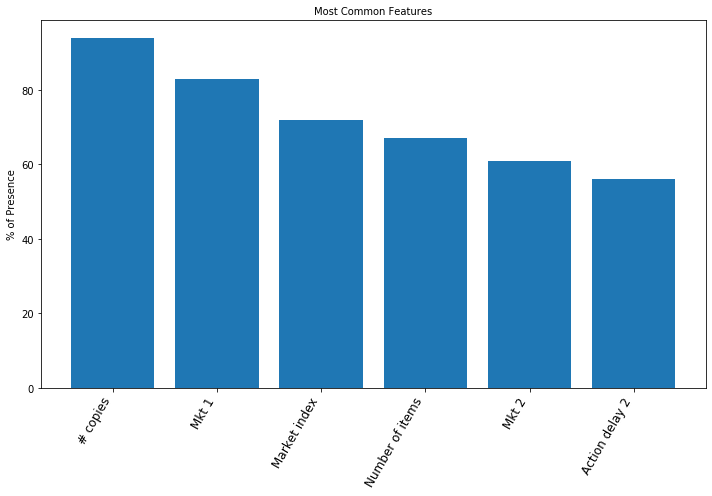

In [448]:
counts_final = (round(counts.loc[list(single['common features'].values)],2) * 100).sort_values('counts',ascending=False)


plt.figure(figsize=(10,7))
plt.bar(x=counts_final.index,height=counts_final['counts'])

# Decoration
plt.title('Most Common Features', fontsize=10)
plt.ylabel('% of Presence')
plt.xticks(rotation=60, horizontalalignment='right', fontsize=12)
plt.tight_layout()
plt.savefig('importance.png')

In [287]:
pd.DataFrame(summary['natural sciences'].value_counts())[0:3]

,natural sciences
Market index,3
# copies,3
Cons years covered,2


In [290]:
pd.DataFrame(summary['social sciences'].value_counts())[0:3]

,social sciences
Mkt 1,3
# copies,3
Market index,3


In [244]:
pd.DataFrame(summary['spanish'].value_counts())[0:3]

,spanish
Cons years covered,3
# copies,3
Mkt 2,3


In [291]:
pd.DataFrame(summary['mathematics'].value_counts())[0:3]

,mathematics
# copies,3
Mkt 3,3
Mkt 1,3


In [292]:
pd.DataFrame(summary['music'].value_counts())[0:3]

,music
Mkt 3,3
# copies,3
Action delay 3,3


In [293]:
pd.DataFrame(summary['religion'].value_counts())[0:3]

,religion
Area covered by seller,3
Action delay 2,2
Number of items,2


#### Test Set

In [541]:
test_scores = {}

In [542]:
for i in subject_dict.values():

    df_test = pd.read_csv(os.path.join(file_path,'testset.csv'))
    
    subject = i
    
    df_test = df_test[(df_test['Subject']==subject)]
    customer_heading = df_test['Customer heading'].values
    
    df_test = df_test.drop(['Customer heading','Subject'],axis=1).values
    
    best_model = best_models_voting[i]
          
    predictions_model = best_model.predict_proba(df_test)[:,1]
    
    
    test_scores[i] = [*zip(customer_heading,predictions_model)] # save score to another dictionary

In [543]:
## natural sciences

natural_sciences = pd.DataFrame(test_scores['natural sciences'],columns=['Customer heading','predictions'])

natural_sciences.to_csv(os.path.join(file_path,'natural_sciences.csv'))

In [544]:
## natural sciences

social_sciences = pd.DataFrame(test_scores['social sciences'],columns=['Customer heading','predictions'])

social_sciences.to_csv(os.path.join(file_path,'social_sciences.csv'))

In [545]:
## spanish

spanish = pd.DataFrame(test_scores['spanish'],columns=['Customer heading','predictions'])

spanish.to_csv(os.path.join(file_path,'spanish.csv'))

In [546]:
## spanish

mathematics = pd.DataFrame(test_scores['mathematics'],columns=['Customer heading','predictions'])

mathematics.to_csv(os.path.join(file_path,'mathematics.csv'))

In [547]:
## music

music = pd.DataFrame(test_scores['music'],columns=['Customer heading','predictions'])

music.to_csv(os.path.join(file_path,'music.csv'))

In [548]:
## spanish

religion = pd.DataFrame(test_scores['religion'],columns=['Customer heading','predictions'])

religion.to_csv(os.path.join(file_path,'religion.csv'))